# Main usage of Novae

This tutorial shows how to load a Novae model, apply it on your spatial data, and plot results. We show usage on spatial data with single-cell resolution (e.g., Xenium, MERSCOPE), but we will also soon make a tutorial for spot resolution data (e.g. Visium).

Make sure you have installed Novae as detailed in the [installation guide](../../getting_started), e.g. using `pip install novae`

> Note: this tutorial is still in progress.

In [12]:
import novae

## Create and process your AnnData object(s)

Novae's input is one or multiple [`AnnData`](https://anndata.readthedocs.io/en/latest/) object(s). Having multiple `AnnData` objects can be useful when you have multiple gene panels, or if you don't want to concatenate your slides. See [here](../input_modes) for more details on all the 4 possible input modes for Novae.

For this tutorial, we first show an example on one `AnnData` object representing a colon slide. We load it with the [`load_dataset`](../../api/novae.utils/#novae.utils.load_dataset) function.

In [13]:
adata = novae.utils.load_dataset(tissue="colon", species="human", pattern=".*P2.*")[0]
adata

[INFO] (novae.utils._data) Found 1 h5ad file(s) matching the filters.


AnnData object with n_obs × n_vars = 340837 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'slide_id', 'technology'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p', 'neighbors', 'spatial_neighbors', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Then, **preprocessing is not mandatory**, as it can be handled by Novae. Here is some extra information:
- You can have either "log1p data" or "raw counts" in `adata.X`. In the latter case, Novae will preprocess it and save the counts in `adata.obsm`.
- Novae runs on a Delaunay graph. If not existing, we create it manually based on `adata.obsm["spatial"]`. See [`novae.utils.spatial_neighbors`](../../api/novae.utils/#novae.utils.spatial_neighbors) for more details, or if you want to specify specific parameters during the graph creation.
- We automatically select the genes that should be used by Novae. We use the highly variable genes (or eventually other genes, if not enough HVG).

## One slide inference
First, we need to load a pretrained Novae model.

Since we have a human colon slide, we load the `"MICS-Lab/novae-human-0"` model, which can be used on any human tissue for spatial data with single-cell resolution. Other model names can be found [here](https://huggingface.co/collections/MICS-Lab/novae-669cdf1754729d168a69f6bd) (spot-resolution models, e.g. for Visium data, will come soon).

In [14]:
model = novae.Novae.from_pretrained("MICS-Lab/novae-human-0")
model

Novae model
   ├── Known genes: 60697
   ├── Parameters: 32.0M
   └── Model name: MICS-Lab/novae-human-0

Now, we can compute the spatial representations for each cell. In the first option below, we pass the argument `zero_shot=True` to run only inference (i.e., the model is not re-trained).

Instead of zero-shot, if you want to fine-tune the model, you can use the [`fine_tune`](../../api/novae.Novae/#novae.Novae.fine_tune) method, and then call [`compute_representations`](../../api/novae.Novae/#novae.Novae.compute_representations) without the `zero_shot` argument (see "option 2").

In [15]:
# Option 1: zero-shot
model.compute_representations(adata, zero_shot=True)

# Option 2: fine-tuning
model.fine_tune(adata)
model.compute_representations(adata)

Computing representations:   0%|          | 0/666 [00:00<?, ?it/s]

To assign domains, you can use the [`assign_domains`](../../api/novae.Novae/#novae.Novae.assign_domains) method, as below. By default, it creates 7 domains, but you can choose the number of domains you want with the `level` argument.

The function will save the domains in `adata.obs`, and return the name of the column in which it was saved (in this case, `adata.obs["novae_domains_7"]`)

In [16]:
model.assign_domains(adata)

'novae_domains_7'

Then, to show the results, you can use [novae.plot.domains](../../api/novae.plot/#novae.plot.domains).

> You can also use [scanpy.pl.spatial](https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pl.spatial.html). Actually, `novae.plot.domains` uses Scanpy internally, but adds extra functionnalities related to Novae.

If you run `model.assign_domains` multiple times, you can also decide the resolution you want to show, by passing the `obs_key` argument to `novae.plot.domains`.

[INFO] (novae.utils._validate) Using obs_key='novae_domains_7' as default.


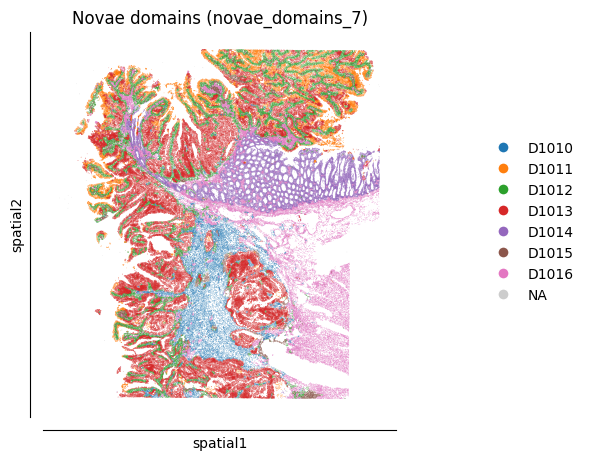

In [17]:
novae.plot.domains(adata)

Novae has a hierarchical organization of the spatial domains. That is, if you run multiple times [`assign_domains`](../../api/novae.Novae/#novae.Novae.assign_domains) with different `level` parameters, the domains at different resolutions will be nested inside each other.

To plot the hierarchy of the domains, you can use the [`plot_domains_hierarchy`](../../api/novae.Novae/#novae.Novae.plot_domains_hierarchy) method of Novae, as below:

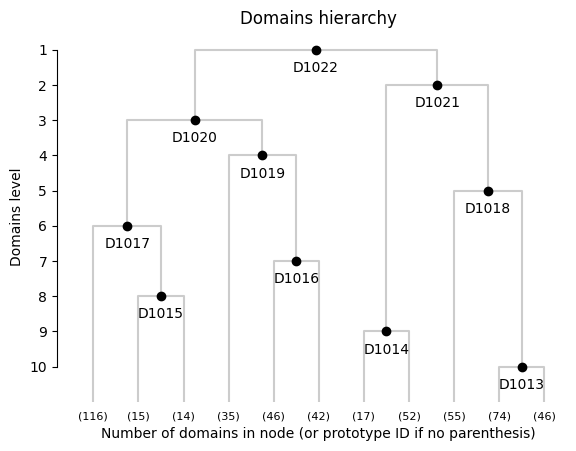

In [18]:
model.plot_domains_hierarchy()

## Multi-slide or multi-panel

You can use Novae on multiple slides or multiple panels. In that case, the input slightly change: you can for instance have one `AnnData` object with a column which indicated the slide ID (if you they share the same gene panel), or have a list of `AnnData` objects (one for each slide, or for each panel). For more details, refer to [this tutorial](../input_modes).

Here, we load 6 mouse brain slides. `adatas` is therefore a list of 6 `AnnData` objects.

In [19]:
adatas = novae.utils.load_dataset(tissue="brain", species="mouse")

[INFO] (novae.utils._data) Found 6 h5ad file(s) matching the filters.


In [20]:
# adata object of the first slide 
adatas[0]

AnnData object with n_obs × n_vars = 53913 × 346
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'slide_id', 'technology'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p', 'neighbors', 'novae_tissue', 'spatial_neighbors', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Since we now work on mouse brain data, we'll load the brain model, as below.

Reminder: for human tissues, you can use the `"MICS-Lab/novae-human-0"` model. Again, other model names can be found [here](https://huggingface.co/collections/MICS-Lab/novae-669cdf1754729d168a69f6bd).

In [21]:
model = novae.Novae.from_pretrained("MICS-Lab/novae-brain-0")
model

Novae model
   ├── Known genes: 60697
   ├── Parameters: 32.0M
   └── Model name: MICS-Lab/novae-brain-0

Then, the usage of Novae is similar as above, and you can again use zero-shot or fine-tuning (see the first section of this tutorial for more details).

Below, we show 3 options, depending on the type of input you have.

In [22]:
# Option 1: one AnnData object is one slide
model.compute_representations(adatas, zero_shot=True)

# Option 2: one AnnData object with multiple slides
# In that case, you need to precise the name of the column in adata.obs
# that contains the slide identifiers.
model.compute_representations(adata, zero_shot=True, slide_key="slide_id")

# Option 3: multiple AnnData objects, each containing multiple slides
# Similarly, you can pass a list of AnnData objects, and precise the slide_key
model.compute_representations(adatas, zero_shot=True, slide_key="slide_id")

Computing representations:   0%|          | 0/106 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/115 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/122 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/115 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/114 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/117 [00:00<?, ?it/s]

Again, the command line to assign domains is the same. Here, we assigned 15 domains.

In [23]:
model.assign_domains(adatas, level=15)

'novae_domains_15'

And, again, we can show domains:

> Here, we added the `slide_name_key` argument, which is optionnal and used to display the name of each slide ( `slide_name_key` should be a column name of `adata.obs`).

[INFO] (novae.utils._validate) Using obs_key='novae_domains_15' as default.


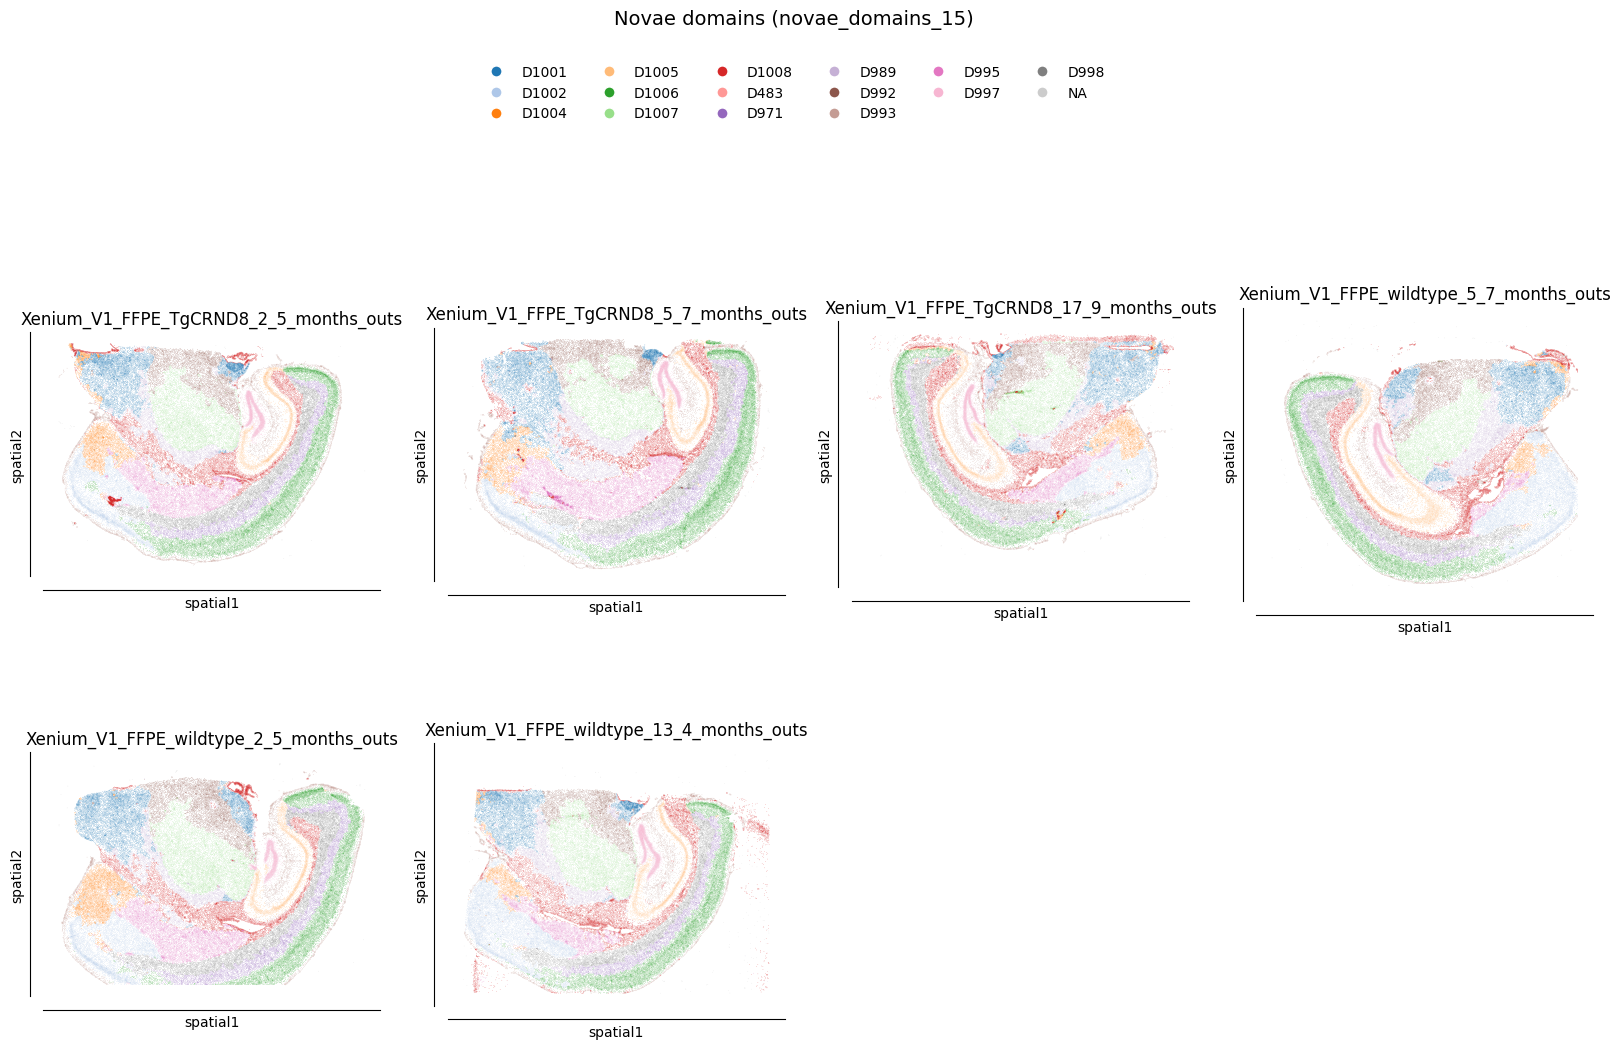

In [24]:
novae.plot.domains(adatas, slide_name_key="slide_id")

## Batch-effect correction of the spatial representations

The spatial representations of each cell are stored in `adata.obsm["novae_latent"]`, and they are not batch-effect corrected by default. Yet, the (categorical) spatial domains **are** corrected. Therefore, we can use the categorical spatial domains to correct the representations, using the [`batch_effect_correction`](../../api/novae.Novae/#novae.Novae.batch_effect_correction) method, as below:

In [25]:
model.batch_effect_correction(adatas)

[INFO] (novae.utils._validate) Using obs_key='novae_domains_15' as default.


This saved the corrected representations inside `adata.obsm["novae_latent_corrected"]`. You can use these corrected representations for further analysis.

Note that this representation is a **spatial domain representation** of each cell, not a **cell expression** representation. Indeed, it contains the information of the local neighborhoods of the cells.

## Downstream analysis

Downstream analysis can be performed with Novae. We illustrated it below.

### Domains proportion per slide

A first simple thing to do is to look at the proportion of each domain for each slide. For instance, you may be interested in finding domains that are more or less present under certain conditions or diseases.

> Again, the `slide_name_key` is optionnal, and is only used to show the slides names.

Here, on our mouse brain slides, we see a homogeneous domains proportions (which is expected, in this specific case).

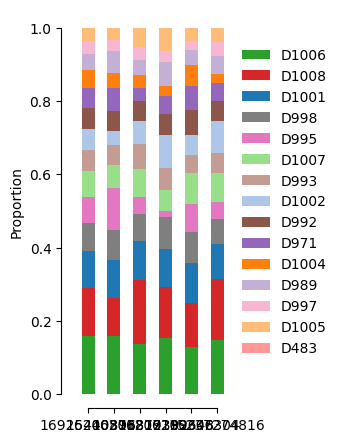

In [28]:
novae.plot.domains_proportions(adatas, obs_key="novae_domains_15")

### Slide architecture

We run trajectory inference (PAGA) on the spatial domains to extract a graph representing the "architecture" of a slide, or the "spatial domains organization".

> Currently, this function only supports one slide per call.

[INFO] (novae.utils._validate) Using obs_key='novae_domains_15' as default.


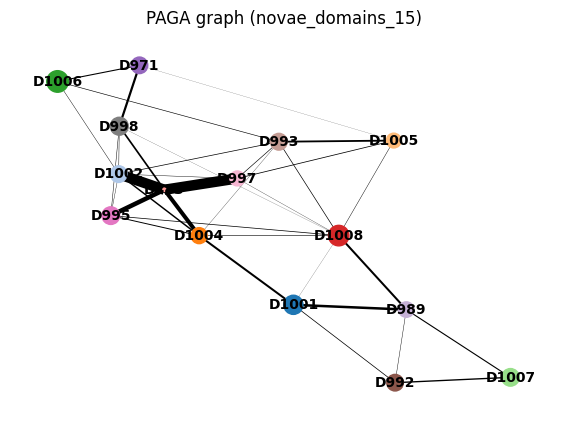

In [29]:
novae.plot.paga(adatas[0])

### Spatially Variable Genes (SVG)

To extract SVG, we run DEGs on the categorical spatial domains. The function below shows the 3 most variable genes.

[INFO] (novae.utils._validate) Using obs_key='novae_domains_15' as default.


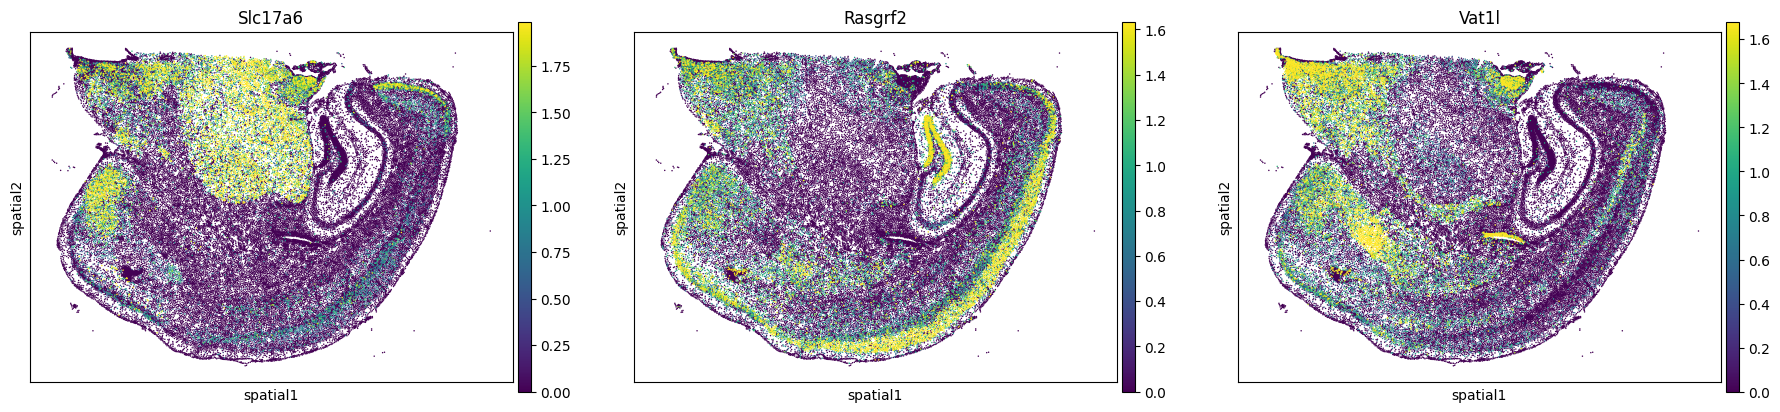

In [30]:
novae.plot.spatially_variable_genes(adatas[0], top_k=3, vmax="p95", cell_size=20)

### Spatial pathway analysis

#### Scores per domain
We can score pathways for each domain using [`scanpy.tl.score_genes`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes.html).

The pathways input should be one of the following:
- a JSON file downloaded from the [GSEA website](https://www.gsea-msigdb.org/gsea/msigdb/index.jsp).
- a `dict` whose keys are pathway names, and values are list of genes (case insensitive).

> Currently, this function only supports one slide per call.

[INFO] (novae.utils._validate) Using obs_key='novae_domains_15' as default.
[INFO] (novae.plot._heatmap) Loaded 50 pathway(s)
/Users/quentinblampey/dev/novae/novae/plot/_heatmap.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(obs_key).mean()


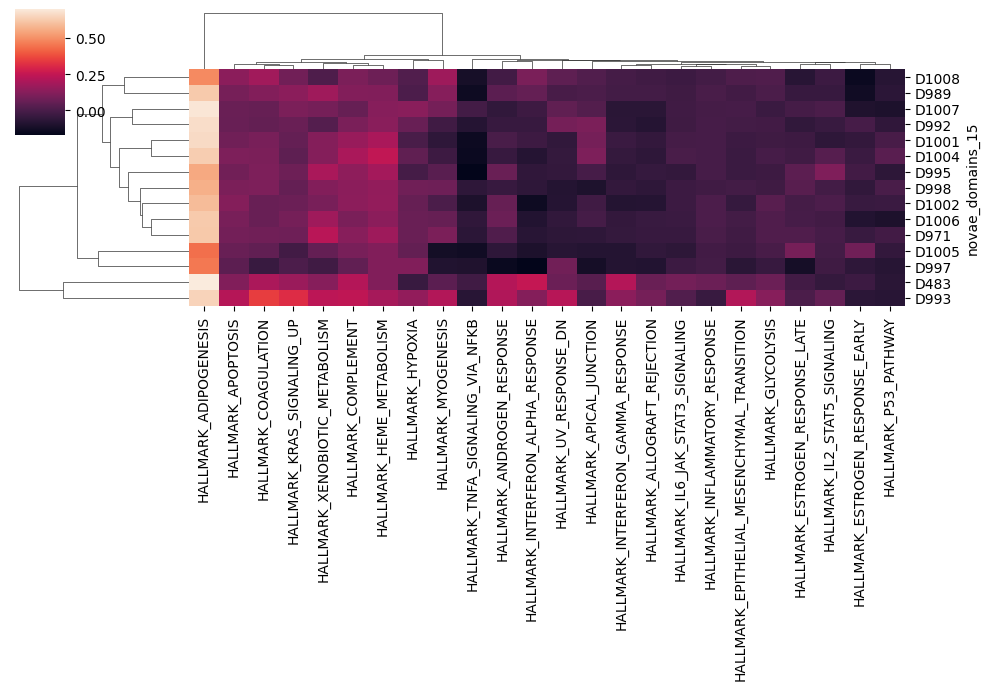

In [31]:
novae.plot.pathway_scores(adatas[0], pathways="mouse_hallmarks.json", figsize=(10, 7))

#### Scores per slide per domain

We can also show the score of one pathway, for each slide and each domain, as in the article.

In [ ]:
# Coming soon (TODO)